In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
# to make plots match dark theme in jupyter lab
plt.style.use('dark_background')

In [2]:
df1 = pd.read_csv('data/Metro_Zhvi_SingleFamilyResidence.csv')

In [3]:
df1.head()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02
0,102001,United States,0,106409.0,106560.0,106737.0,106910.0,107128.0,107351.0,107614.0,...,238053,238779,239549,240338,241143,241961,242760,243578,244440,245386
1,394913,"New York, NY",1,189376.0,189043.0,188739.0,188553.0,188461.0,188504.0,188629.0,...,475533,475912,476471,477020,477381,477515,477746,478297,479081,479971
2,753899,"Los Angeles-Long Beach-Anaheim, CA",2,192140.0,192143.0,192208.0,192359.0,192348.0,192275.0,192216.0,...,685436,686283,687894,690303,693953,697273,700235,704585,710138,718974
3,394463,"Chicago, IL",3,162321.0,161707.0,161373.0,160886.0,161449.0,162263.0,163930.0,...,243265,243491,243848,244063,244154,244153,244137,244226,244415,244624
4,394514,"Dallas-Fort Worth, TX",4,113140.0,113481.0,113727.0,113913.0,114131.0,114357.0,114688.0,...,252542,253044,253660,254304,255076,255509,255856,255972,256267,256718


In [4]:
df1.shape

(914, 290)

In [5]:
# Lets remove United States and focus on city and state
state_df = df1.iloc[1:, :].copy()

In [6]:
# Drop unneeded columns
state_df.drop(['RegionID', 'SizeRank'], inplace=True, axis=1)

In [7]:
# make YY-MM columns start on the first to make our lives easier
state_df.rename(dict(zip(state_df.columns[1:], [f'{c}-01' for c in state_df.columns[1:]])), 
                inplace=True, axis='columns')

In [8]:
# Split RegionName into city and state
state_df['City'] =  [x.split(', ')[0] for x in state_df['RegionName']]
state_df['State'] = [y.split(', ')[1] for y in state_df['RegionName']]
state_df.drop(['RegionName'], inplace=True, axis=1)

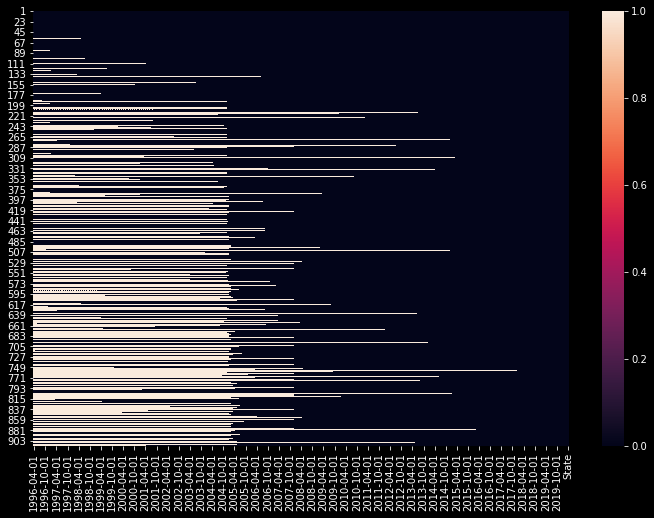

In [9]:
# Lets see the null values
plt.figure(figsize=(12, 8))
sns.heatmap(state_df.isna());

In [10]:
state_df.set_index('City', inplace=True)

In [11]:
# Make time series by state code
def state_df_maker(state_code):
    if type(state_code) != str:
        type(state_code) == str
    state_data = state_df[state_df['State'] == state_code.upper()].copy()
    state_data.reset_index(inplace=True)
    state_data = state_data.transpose()
    state_data.columns = state_data.iloc[0]
    state_data.drop(state_data.index[0], inplace=True)
    # convert to numeric, ignore the NaNs
    state_data.apply(pd.to_numeric, errors='ignore')
    state_data.index = pd.to_datetime(state_data.index, format="%Y-%m-%d", errors='coerce')
    # We dont need the state code
    return state_data[:-1]

In [12]:
ohio_df = state_df_maker('OH')

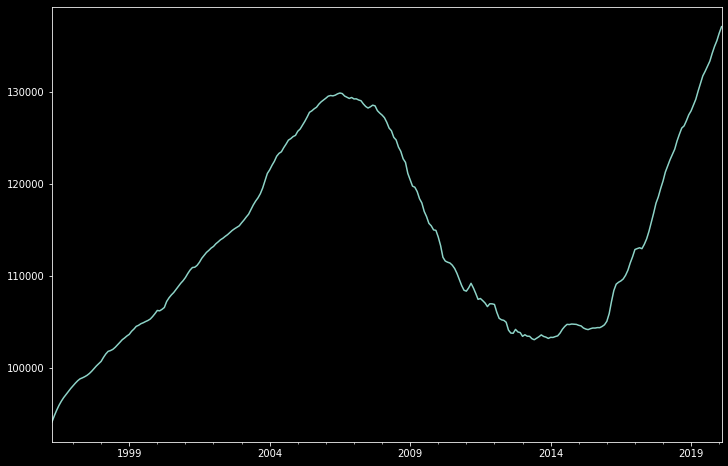

In [13]:
plt.figure(figsize=(12, 8))
ohio_df['Dayton'].plot();

"""
What things could effect the housing market
Dates range from 04/96 - 02/20
"""

# Sources to get data 
### Idea for corona virus - deaths from virus vs economy
* https://www.economicshelp.org/blog/377/housing/factors-that-affect-the-housing-market/ 
* https://fred.stlouisfed.org/ 
    * CPIAUCSL.csv - https://fred.stlouisfed.org/series/CPIAUCSL
    * A191RL1Q225SBEA.csv - https://fred.stlouisfed.org/series/A191RL1Q225SBEA
    * UNRATE.csv - https://fred.stlouisfed.org/series/UNRATE
    * INDPRO.csv - https://fred.stlouisfed.org/series/INDPRO
    * FEDFUNDS.csv - https://fred.stlouisfed.org/series/FEDFUNDS
* ^DJI.csv - https://finance.yahoo.com/quote/%5EDJI/historyperiod1=828316800&period2=1580515200&interval=1mo&filter=history&frequency=1mo
* ^GSPC.csv - https://finance.yahoo.com/quote/%5EGSPC/historyperiod1=828316800&period2=1580515200&interval=1mo&filter=history&frequency=1mo

In [20]:
for file in os.listdir('data'):
    if file.endswith('.csv'):
        print(file)

A191RL1Q225SBEA.csv
CPIAUCSL.csv
FEDFUNDS.csv
INDPRO.csv
Metro_Zhvi_SingleFamilyResidence.csv
State_Zhvi_SingleFamilyResidence.csv
UNRATE.csv
^DJI.csv
^GSPC.csv
